Import Libraries

In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config
from flax import linen as nn

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# choose GPU
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'
jax.config.update("jax_enable_x64", True)

In [2]:
n_gpu = len(jax.devices())
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0)]

General PDE form:

    𝜕𝑢/𝜕𝑡 + [𝛼+𝛽𝑢]𝜕𝑢/𝜕𝑥 − 𝛾(𝜕𝑥^2𝑢)/(𝜕𝑥^2) + 𝛿(𝜕𝑥^3𝑢)/(𝜕𝑥^3) = 𝑞(𝑥,𝑡)

        1. Heat equation (𝛼,𝛽,𝛾,𝛿) = (0,0,𝛾,0)
        2. Convection-diffusion equation (𝛼,𝛽,𝛾,𝛿) = (1,0,𝛾,0)
        3. Burgers’ equation (𝛼,𝛽,𝛾,𝛿) = (0,1,𝛾,0)
        4. KDV equation (𝛼,𝛽,𝛾,𝛿) = (0,1,0,𝛿)

    IC : 𝑢(𝑥,0) = 𝑞(𝑥,0)
    Periodic BC : 𝑥∈[0,𝐿]

Create tasks over distribution

In [3]:
# train
case_all = jnp.array([[1, 1, 0, 0.001 , 0.001],
                      [2, 1, 0, 0.0005, 0.001],
                      [3, 1, 0, 0     , 0.001],
                      [4, 1, 0, 0.001 , 0.0005],
                      [5, 1, 0, 0.0005, 0.0005],
                      [6, 1, 0, 0     , 0.0005],
                      [7, 1, 0, 0.001 , 0],
                      [8, 1, 0, 0.0005, 0],
                      [9, 1, 0, 0     , 0]])
seed_all = jnp.hstack([jnp.arange(9), jnp.arange(12, 15)])  # IC
task_all = jnp.hstack([jnp.repeat(seed_all, repeats=len(case_all)).reshape(-1, 1),
                       jnp.tile(case_all, (len(seed_all),1))])
n_task = len(task_all)
print ('no. tasks = %d\n%s'%(n_task, task_all[:5]))

no. tasks = 108
[[0.e+00 1.e+00 1.e+00 0.e+00 1.e-03 1.e-03]
 [0.e+00 2.e+00 1.e+00 0.e+00 5.e-04 1.e-03]
 [0.e+00 3.e+00 1.e+00 0.e+00 0.e+00 1.e-03]
 [0.e+00 4.e+00 1.e+00 0.e+00 1.e-03 5.e-04]
 [0.e+00 5.e+00 1.e+00 0.e+00 5.e-04 5.e-04]]


In [4]:
# spatial domain
x_l, x_u = 0.0, 1.0
x_d = x_u - x_l # domain length

# time domain: 0 - t_T (only use half of the domain!)
t_T = 2.0

In [5]:
# load tasks and target label
x_train = jnp.load(os.path.join('data_meta_pdes', 'cds_input.npy'))
y_train_all = jnp.load(os.path.join('data_meta_pdes', 'cds_label.npy'))
print (x_train.shape, y_train_all.shape)

(5151, 2) (108, 5151, 1)


In [6]:
# split x_train into PDE, IC & BC
_ic, _bc = (x_train[:,1] == 0), (x_train[:,0] == x_l) #| (x_train[:,0] == x_u) # periodic BC - only query x_l
data_pde, data_ic, data_bc = x_train[~(_ic|_bc)], x_train[_ic], x_train[_bc & ~_ic]
batch_data_pde, batch_data_ic, batch_data_bc = data_pde, data_ic, data_bc
print (batch_data_pde.shape, batch_data_ic.shape, batch_data_bc.shape)

(5000, 2) (101, 2) (50, 2)


[5.e+00 1.e+00 1.e+00 0.e+00 1.e-03 1.e-03]


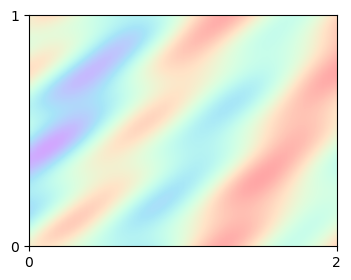

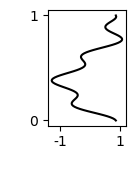

In [7]:
# plot 1 example solution
task = 45
y_train = y_train_all[task]
# plot
fig = plt.figure(figsize=(10, 3))
ext = [0, 2, x_l, x_u]     # plot boundary
u_plot = (y_train.reshape(51, -1)).T
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.5, alpha=.35);
plt.yticks([0,1], [0,1]); plt.xticks([0,2], [0,2]);
print (task_all[task])

# plot IC profile
fig = plt.figure(figsize=(1, 1.5))
plt.plot(u_plot[:,0], jnp.linspace(0, 1, 101), c='k');
plt.yticks([0,1], [0,1]); plt.xticks([-1,1], [-1,1]); plt.xlabel(' '); plt.ylabel(' ');

Define source function - q(x, t)

In [8]:
# coef.
@jit
def sample_coef(rng):
    # generate random sample
    key, rng = random.split(rng) # update random generator
    Ajs = round(random.uniform(key, shape=(J,), minval=-.8, maxval=.8), 2)
    key, rng = random.split(rng) # update random generator
    wjs = round(random.uniform(key, shape=(J,), minval=-2, maxval=2), 2)
    key, rng = random.split(rng) # update random generator
    ljs = round(random.choice(key, jnp.array([0,1,2,3,4]), shape=(J,)), 2)
    key, rng = random.split(rng) # update random generator
    pjs = round(random.uniform(key, shape=(J,), minval=-jnp.pi, maxval=jnp.pi), 2)
    return (Ajs, wjs, ljs, pjs)

# q(x,t)
@jit
def q_xt(x, t, coefs):
    # coef.
    Ajs, wjs, ljs, pjs = coefs
    # obtain q
    q = jnp.zeros_like(x)
    for i in range(J):
        q = q + Ajs[i] * jnp.sin(wjs[i]*t + (2*jnp.pi*ljs[i]*x)/L + pjs[i])
    return q


# hyper-parameter
J = 5
L = 1

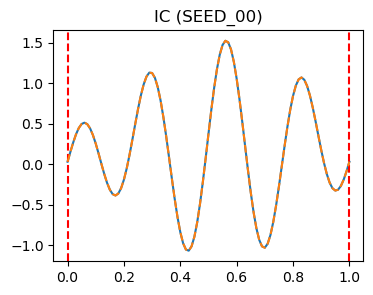

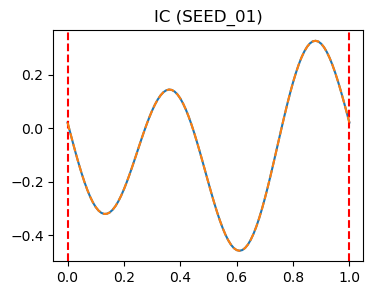

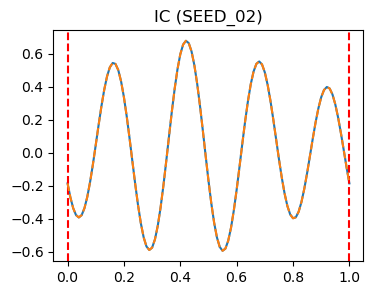

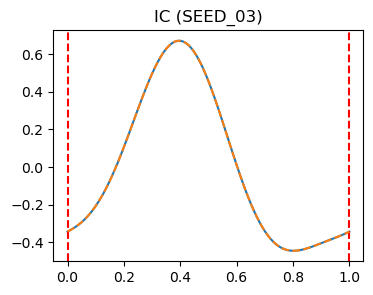

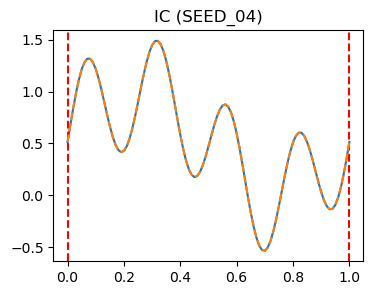

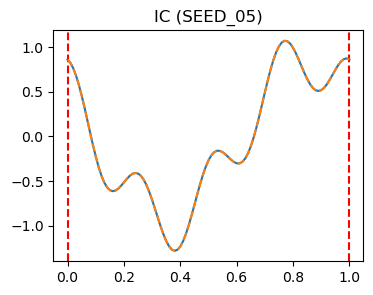

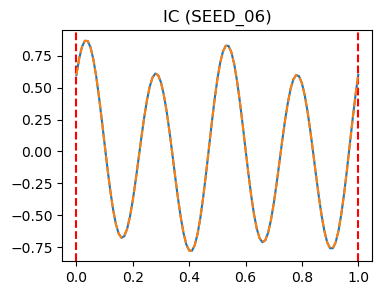

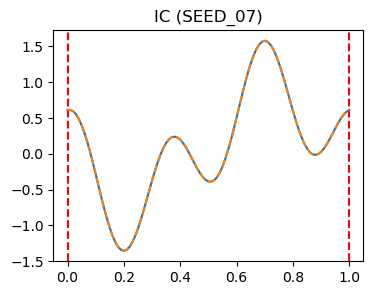

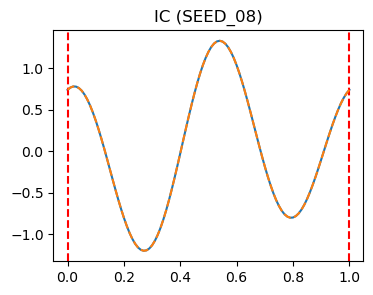

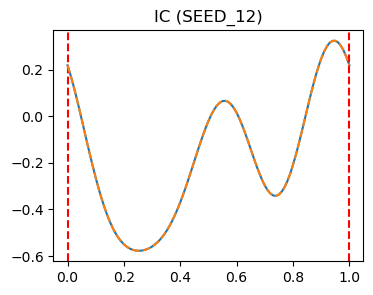

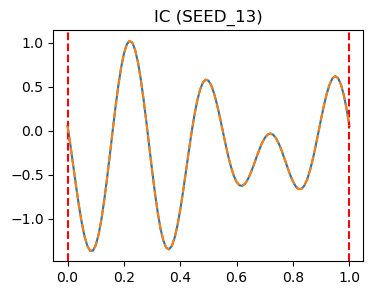

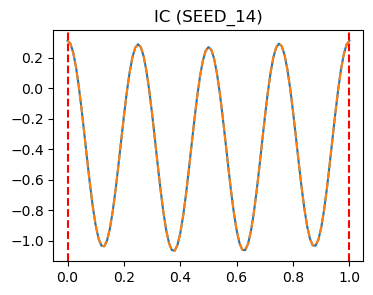

In [9]:
# random q
for task in range(n_task)[::9]:
    t_ic, y_train = int(task_all[task][0]), y_train_all[task]
    coefs = sample_coef(random.split(random.PRNGKey(t_ic))[1])
    # visualize IC
    ic = q_xt(data_ic[:,0], data_ic[:,1], coefs)
    fig = plt.figure(figsize=(4, 3))
    plt.plot(data_ic[:,0], ic); plt.axvline(x=0, c='r', linestyle='--'); plt.axvline(x=1, c='r', linestyle='--');
    plt.plot(data_ic[:,0], y_train[_ic], linestyle='--');
    plt.title('IC (SEED_%02d)'%(t_ic));

Baldwinian PINN (B-PINN)

In [10]:
# construct randomization B-PINN for linear/nonlinear ODE/PDEs
@jit
def get_f(x, t, weights):
    f = jnp.hstack([jnp.sin((x-.5) * weights[0] + t * weights[1] + weights[2]),
                    nn.softplus((x-.5) * weights[3] + t * weights[4] + weights[5]),
                    jnp.tanh((x-.5) * weights[6] + t * weights[7] + weights[8]),
                    jnp.sin((x-.5) * weights[9] + t * weights[10] + weights[11]),
                    nn.softplus((x-.5) * weights[12] + t * weights[13] + weights[14]),
                    jnp.tanh((x-.5) * weights[15] + t * weights[16] + weights[17])])
    return f

# obtain f_t
def get_f_t(get_f, x, t, weights):
    f_t = jacfwd(get_f, argnums=1)(x, t, weights)
    return f_t

# obtain f_x
def get_f_x(get_f, x, t, weights):
    f_x = jacfwd(get_f)(x, t, weights)
    return f_x

#obtain f_xx
def get_f_xx(get_f, x, t, weights):
    f_xx = jacfwd(jacfwd(get_f))(x, t, weights)
    return f_xx

# obtain f_xxx
def get_f_xxx(get_f, x, t, weights):
    f_xxx = jacfwd(jacfwd(jacfwd(get_f)))(x, t, weights)
    return f_xxx

f_t_vmap = vmap(get_f_t, in_axes=(None, 0, 0, None))
f_x_vmap = vmap(get_f_x, in_axes=(None, 0, 0, None))
f_xx_vmap = vmap(get_f_xx, in_axes=(None, 0, 0, None))
f_xxx_vmap = vmap(get_f_xxx, in_axes=(None, 0, 0, None))

Least square problem

In [11]:
# no. neurons
n_node = 200

# generate weight & bias dist.
seed = 1
key, rng = random.split(random.PRNGKey(seed))
key, rng = random.split(rng) # update random generator
weights_n = random.truncated_normal(key, shape=(n_node, 9), lower=-1, upper=1)
key, rng = random.split(rng) # update random generator
weights_u = random.uniform(key, (n_node, 9), minval=-1, maxval=1)

# regularization
lamb = 1e-4

In [12]:
# compute hidden node outputs / derivaties & construct least square problem
@jit
def compute_ls_task(param, task, task_all):
    # generate weight & bias dist. (given param)
    weights = jnp.hstack([weights_n* param[:9] + param[9:18], weights_u* param[18:27] + param[27:-1]]).T
    # generate coefs (given task)
    t_ic, t_para, alpha, beta, gamma, delta = task_all[task]
    t_ic = t_ic.astype(int)
    coefs = sample_coef(random.split(random.PRNGKey(t_ic))[1])
    # populate PDE sub-matrix given sample
    x, t = jnp.array_split(batch_data_pde, 2, axis=1)
    f_t = f_t_vmap(get_f, x, t, weights)[:,:,0]
    f_x = f_x_vmap(get_f, x, t, weights)[:,:,0]
    f_xx = f_xx_vmap(get_f, x, t, weights)[:,:,0,0]
    f_xxx = f_xxx_vmap(get_f, x, t, weights)[:,:,0,0,0]
    # PDE: u_t + (alpha + beta*u)*u_x - gamma*u_xx + delta*u_xxx = q(x,t)
    f_pde = f_t + alpha*f_x - gamma*f_xx + delta*f_xxx
    r_pde = q_xt(x, t, coefs)
    # populate BC sub-matrix given sample (x, t)
    x, t = jnp.array_split(batch_data_bc, 2, axis=1)
    f_bc = get_f(x, t , weights) - get_f(x + x_d, t , weights) # enforce periodic BC
    r_bc = jnp.zeros((f_bc.shape[0], 1))
    # populate IC sub-matrix given sample (x, t)
    x, t = jnp.array_split(batch_data_ic, 2, axis=1)
    f_ic = get_f(x, t, weights)
    r_ic = q_xt(x, t, coefs)
    # construct least square problem
    A = jnp.vstack([f_pde, f_bc, f_ic])
    b = jnp.vstack([r_pde, r_bc, r_ic])
    # alternative solve (n_sample >> n_node)
    reg = lamb *param[-1]
    w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
    ssr = np.sum((b - A @ w)**2)
    return w, ssr, weights

@jit
def compute_ssr_task(param, task):
    # generate weight & bias dist. (given param)
    weights = jnp.hstack([weights_n* param[:9] + param[9:18], weights_u* param[18:27] + param[27:-1]]).T
    # generate coefs (given task)
    t_ic, t_para, alpha, beta, gamma, delta = task_all[task]
    t_ic = t_ic.astype(int)
    coefs = sample_coef(random.split(random.PRNGKey(t_ic))[1])
    # populate PDE sub-matrix given sample
    x, t = jnp.array_split(batch_data_pde, 2, axis=1)
    f_t = f_t_vmap(get_f, x, t, weights)[:,:,0]
    f_x = f_x_vmap(get_f, x, t, weights)[:,:,0]
    f_xx = f_xx_vmap(get_f, x, t, weights)[:,:,0,0]
    f_xxx = f_xxx_vmap(get_f, x, t, weights)[:,:,0,0,0]
    # PDE: u_t + (alpha + beta*u)*u_x - gamma*u_xx + delta*u_xxx = q(x,t)
    f_pde = f_t + alpha*f_x - gamma*f_xx + delta*f_xxx
    r_pde = q_xt(x, t, coefs)
    # populate BC sub-matrix given sample (x, t)
    x, t = jnp.array_split(batch_data_bc, 2, axis=1)
    f_bc = get_f(x, t , weights) - get_f(x + x_d, t , weights) # enforce periodic BC
    r_bc = jnp.zeros((f_bc.shape[0], 1))
    # populate IC sub-matrix given sample (x, t)
    x, t = jnp.array_split(batch_data_ic, 2, axis=1)
    f_ic = get_f(x, t, weights)
    r_ic = q_xt(x, t, coefs)
    # construct least square problem
    A = jnp.vstack([f_pde, f_bc, f_ic])
    b = jnp.vstack([r_pde, r_bc, r_ic])
    # alternative solve (n_sample >> n_node)
    reg = lamb *param[-1]
    w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
    ssr = np.sum((b - A @ w)**2)
    # mse (given task)
    y_train = y_train_all[task]
    x, t = jnp.array_split(x_train, 2, axis=1)
    f = get_f(x, t, weights)
    mse = jnp.mean(jnp.square(y_train - f @ w))  
    return ssr, mse

compute_ssr_task = jax.vmap(compute_ssr_task)
batch_ssr_task = jax.pmap(compute_ssr_task)

In [13]:
# solution
def get_u(x, t, weights):
    f = get_f(x, t, weights)
    return (f @ w)

In [14]:
from evojax.algo import CMA_ES_JAX

stdev = 5.
pop_size = 20
solver = CMA_ES_JAX(
         pop_size=pop_size, init_stdev=stdev, # adjust pop_size and init_stdev (e.g., 0.1, 0.5, 1, 5, 10)
         param_size=37, seed=seed)

# no. task to choose from a distribution
r_task = 15
n_batch = 2

In [15]:
max_iters = 500

store = []

runtime = 0
train_iter = 0
while (runtime < 100000) and (train_iter < max_iters):
    start = time.time()
    # fitness evaluation
    params = solver.ask()
    # repeat for a distribution of task (pop_size * r_task)
    params = jnp.tile(params, (r_task *n_batch, 1)) # repeat for a distribution of task
    key, rng = random.split(rng) # update random generator
    tasks = random.choice(key, n_task, (r_task *n_batch,), replace=False)
    tasks = jnp.repeat(tasks, repeats=pop_size) # repeat for each candidate solution
    # multi GPU runs (x n_batch)
    ssr, mse = [], []
    for s in range(n_batch):
        params_s, task_s = params.reshape(n_batch, int(len(params)/n_batch), -1)[s], tasks.reshape(n_batch, -1)[s]
        ssr_s, mse_s = batch_ssr_task(params_s.reshape(n_gpu, int(len(params_s)/n_gpu), -1), task_s.reshape(n_gpu, -1))
        ssr.append(ssr_s)
        mse.append(mse_s)
    ssr, mse = jnp.vstack(ssr), jnp.vstack(mse)
    ssr, mse = ssr.reshape(-1, pop_size).mean(axis=0), mse.reshape(-1, pop_size).mean(axis=0)
    # updates the weights through the solver
    scores = - (mse + ssr)
    solver.tell(fitness=scores)
    # this is the average loss of all the population of parameters
    maxpos = jnp.argmax(scores)
    end = time.time()
    # update
    runtime += (end - start)
    # print out
    print('Iter = %5d | Time = %.2fs | LOSS = %.2e  || - SSR = %.2e, MSE = %.2e' % (train_iter + 1, runtime, -scores[maxpos],
                                                                                    ssr[maxpos], mse[maxpos]))
    store.append([train_iter + 1, runtime, -scores[maxpos], ssr[maxpos], mse[maxpos]])
    train_iter += 1
    
store = jnp.array(store)

Iter =     1 | Time = 28.20s | LOSS = 9.53e+00  || - SSR = 9.41e+00, MSE = 1.17e-01
Iter =     2 | Time = 50.12s | LOSS = 1.14e+01  || - SSR = 1.12e+01, MSE = 1.79e-01
Iter =     3 | Time = 71.65s | LOSS = 1.14e+01  || - SSR = 1.11e+01, MSE = 2.32e-01
Iter =     4 | Time = 93.20s | LOSS = 7.54e+00  || - SSR = 7.46e+00, MSE = 8.48e-02
Iter =     5 | Time = 114.73s | LOSS = 4.34e+00  || - SSR = 4.29e+00, MSE = 4.54e-02
Iter =     6 | Time = 136.31s | LOSS = 3.07e+00  || - SSR = 3.02e+00, MSE = 4.74e-02
Iter =     7 | Time = 157.87s | LOSS = 3.89e+00  || - SSR = 3.83e+00, MSE = 5.51e-02
Iter =     8 | Time = 179.46s | LOSS = 2.77e+00  || - SSR = 2.66e+00, MSE = 1.12e-01
Iter =     9 | Time = 201.05s | LOSS = 2.07e+00  || - SSR = 1.95e+00, MSE = 1.25e-01
Iter =    10 | Time = 222.65s | LOSS = 1.94e+00  || - SSR = 1.17e+00, MSE = 7.69e-01
Iter =    11 | Time = 244.25s | LOSS = 1.86e-01  || - SSR = 1.71e-01, MSE = 1.42e-02
Iter =    12 | Time = 265.90s | LOSS = 3.89e-01  || - SSR = 3.71e-01,

Iter =    97 | Time = 2105.62s | LOSS = 2.19e-03  || - SSR = 6.70e-04, MSE = 1.52e-03
Iter =    98 | Time = 2127.29s | LOSS = 6.32e-04  || - SSR = 1.95e-04, MSE = 4.36e-04
Iter =    99 | Time = 2148.94s | LOSS = 2.65e-03  || - SSR = 1.26e-03, MSE = 1.39e-03
Iter =   100 | Time = 2170.60s | LOSS = 6.36e-03  || - SSR = 4.77e-04, MSE = 5.89e-03
Iter =   101 | Time = 2192.25s | LOSS = 7.10e-03  || - SSR = 2.31e-03, MSE = 4.79e-03
Iter =   102 | Time = 2213.90s | LOSS = 1.41e-03  || - SSR = 3.55e-04, MSE = 1.05e-03
Iter =   103 | Time = 2235.55s | LOSS = 4.79e-04  || - SSR = 1.42e-04, MSE = 3.36e-04
Iter =   104 | Time = 2257.20s | LOSS = 7.60e-04  || - SSR = 1.79e-04, MSE = 5.80e-04
Iter =   105 | Time = 2278.85s | LOSS = 2.48e-03  || - SSR = 2.89e-04, MSE = 2.19e-03
Iter =   106 | Time = 2300.49s | LOSS = 5.19e-03  || - SSR = 1.96e-03, MSE = 3.23e-03
Iter =   107 | Time = 2322.14s | LOSS = 9.14e-04  || - SSR = 4.58e-04, MSE = 4.55e-04
Iter =   108 | Time = 2343.80s | LOSS = 1.23e-03  || -

Iter =   193 | Time = 4184.68s | LOSS = 1.02e-03  || - SSR = 2.74e-04, MSE = 7.46e-04
Iter =   194 | Time = 4206.33s | LOSS = 5.47e-04  || - SSR = 4.20e-04, MSE = 1.27e-04
Iter =   195 | Time = 4227.98s | LOSS = 5.78e-04  || - SSR = 9.56e-05, MSE = 4.82e-04
Iter =   196 | Time = 4249.63s | LOSS = 6.53e-04  || - SSR = 5.80e-04, MSE = 7.28e-05
Iter =   197 | Time = 4271.28s | LOSS = 3.24e-04  || - SSR = 2.74e-04, MSE = 4.92e-05
Iter =   198 | Time = 4292.93s | LOSS = 3.18e-04  || - SSR = 2.02e-04, MSE = 1.16e-04
Iter =   199 | Time = 4314.58s | LOSS = 3.51e-04  || - SSR = 2.37e-04, MSE = 1.14e-04
Iter =   200 | Time = 4336.23s | LOSS = 4.62e-04  || - SSR = 2.03e-04, MSE = 2.60e-04
Iter =   201 | Time = 4357.88s | LOSS = 1.59e-03  || - SSR = 8.34e-04, MSE = 7.56e-04
Iter =   202 | Time = 4379.53s | LOSS = 7.25e-04  || - SSR = 5.43e-04, MSE = 1.81e-04
Iter =   203 | Time = 4401.18s | LOSS = 5.80e-04  || - SSR = 3.85e-04, MSE = 1.94e-04
Iter =   204 | Time = 4422.82s | LOSS = 5.74e-04  || -

Iter =   289 | Time = 6261.77s | LOSS = 2.42e-04  || - SSR = 1.13e-04, MSE = 1.30e-04
Iter =   290 | Time = 6283.41s | LOSS = 2.71e-04  || - SSR = 1.63e-04, MSE = 1.08e-04
Iter =   291 | Time = 6305.04s | LOSS = 4.40e-04  || - SSR = 1.06e-04, MSE = 3.34e-04
Iter =   292 | Time = 6326.68s | LOSS = 3.10e-04  || - SSR = 1.96e-04, MSE = 1.14e-04
Iter =   293 | Time = 6348.32s | LOSS = 2.57e-04  || - SSR = 7.67e-05, MSE = 1.80e-04
Iter =   294 | Time = 6369.95s | LOSS = 3.47e-04  || - SSR = 1.04e-04, MSE = 2.43e-04
Iter =   295 | Time = 6391.59s | LOSS = 1.97e-04  || - SSR = 6.88e-05, MSE = 1.28e-04
Iter =   296 | Time = 6413.23s | LOSS = 1.47e-04  || - SSR = 9.22e-05, MSE = 5.45e-05
Iter =   297 | Time = 6434.86s | LOSS = 3.46e-04  || - SSR = 1.27e-04, MSE = 2.19e-04
Iter =   298 | Time = 6456.49s | LOSS = 4.20e-04  || - SSR = 1.46e-04, MSE = 2.74e-04
Iter =   299 | Time = 6478.12s | LOSS = 1.39e-04  || - SSR = 1.28e-04, MSE = 1.10e-05
Iter =   300 | Time = 6499.75s | LOSS = 2.03e-04  || -

Iter =   385 | Time = 8339.10s | LOSS = 2.02e-04  || - SSR = 1.40e-04, MSE = 6.22e-05
Iter =   386 | Time = 8360.75s | LOSS = 1.86e-04  || - SSR = 1.12e-04, MSE = 7.40e-05
Iter =   387 | Time = 8382.40s | LOSS = 2.83e-04  || - SSR = 1.78e-04, MSE = 1.05e-04
Iter =   388 | Time = 8404.05s | LOSS = 1.98e-04  || - SSR = 7.88e-05, MSE = 1.19e-04
Iter =   389 | Time = 8425.70s | LOSS = 1.41e-04  || - SSR = 9.99e-05, MSE = 4.14e-05
Iter =   390 | Time = 8447.34s | LOSS = 2.40e-04  || - SSR = 1.27e-04, MSE = 1.14e-04
Iter =   391 | Time = 8468.99s | LOSS = 1.41e-04  || - SSR = 8.86e-05, MSE = 5.19e-05
Iter =   392 | Time = 8490.64s | LOSS = 2.03e-04  || - SSR = 1.40e-04, MSE = 6.29e-05
Iter =   393 | Time = 8512.29s | LOSS = 1.74e-04  || - SSR = 1.49e-04, MSE = 2.50e-05
Iter =   394 | Time = 8533.94s | LOSS = 1.99e-04  || - SSR = 1.46e-04, MSE = 5.33e-05
Iter =   395 | Time = 8555.58s | LOSS = 2.31e-04  || - SSR = 1.60e-04, MSE = 7.11e-05
Iter =   396 | Time = 8577.23s | LOSS = 1.16e-04  || -

Iter =   481 | Time = 10417.38s | LOSS = 1.26e-04  || - SSR = 8.00e-05, MSE = 4.59e-05
Iter =   482 | Time = 10439.03s | LOSS = 1.22e-04  || - SSR = 7.97e-05, MSE = 4.23e-05
Iter =   483 | Time = 10460.68s | LOSS = 9.65e-05  || - SSR = 7.28e-05, MSE = 2.37e-05
Iter =   484 | Time = 10482.33s | LOSS = 8.88e-05  || - SSR = 6.59e-05, MSE = 2.29e-05
Iter =   485 | Time = 10503.98s | LOSS = 1.27e-04  || - SSR = 9.61e-05, MSE = 3.11e-05
Iter =   486 | Time = 10525.63s | LOSS = 9.41e-05  || - SSR = 7.58e-05, MSE = 1.84e-05
Iter =   487 | Time = 10547.28s | LOSS = 9.00e-05  || - SSR = 7.15e-05, MSE = 1.85e-05
Iter =   488 | Time = 10568.93s | LOSS = 8.57e-05  || - SSR = 6.36e-05, MSE = 2.21e-05
Iter =   489 | Time = 10590.58s | LOSS = 1.14e-04  || - SSR = 8.81e-05, MSE = 2.62e-05
Iter =   490 | Time = 10612.22s | LOSS = 1.11e-04  || - SSR = 8.47e-05, MSE = 2.61e-05
Iter =   491 | Time = 10633.87s | LOSS = 1.04e-04  || - SSR = 7.79e-05, MSE = 2.65e-05
Iter =   492 | Time = 10655.52s | LOSS = 8.

In [16]:
solver.best_params

DeviceArray([ 7.39666161e+00, -1.60114372e+01, -2.06785804e+01,
              1.76049996e+01,  8.51754992e+00, -1.20336953e+01,
             -2.04211160e+01,  4.57475021e+00, -1.45929844e+00,
              1.25340898e+01, -1.09585141e+01, -4.99467803e+01,
             -4.79885638e-01, -1.67582993e+01,  1.08705669e+01,
              1.07217185e+01,  2.04309275e+01, -2.22964789e+01,
              2.71557078e-04, -4.22479196e+01,  2.72331440e+01,
              1.46436347e+01,  3.79293837e+01,  2.28009593e+01,
             -1.73060055e+01,  3.02292140e+00,  8.41328634e-01,
             -2.51256693e+01,  1.30770700e+01,  1.26241360e+01,
              2.51571009e+01, -2.66116707e+01, -2.89989421e-01,
              1.41600037e+01,  6.98822747e+00, -1.27721170e+01,
              3.49901433e+01], dtype=float64)

Convergence & prediction on [ train ] tasks

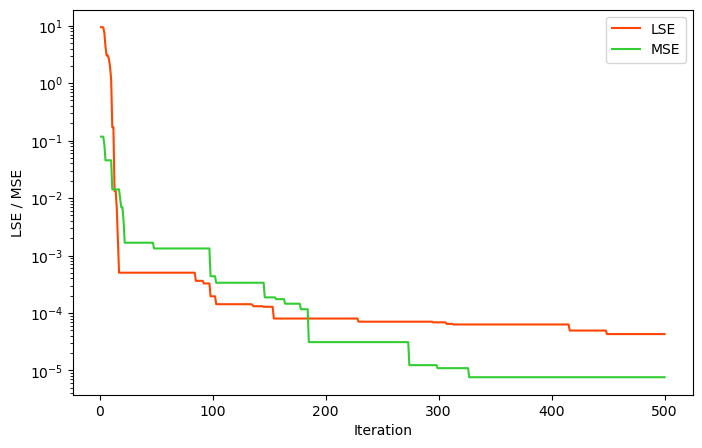

In [17]:
# plot convergence
fig = plt.figure(figsize=(8, 5))
# smooth the MSE & SSR
_mse = np.array(store[:,4].copy())
for i in range(1, len(_mse)): _mse[i] = min(_mse[i], _mse[i-1])  
_ssr = np.array(store[:,3].copy())
for i in range(1, len(_ssr)): _ssr[i] = min(_ssr[i], _ssr[i-1])  
plt.plot(store[:,0], _ssr, label='LSE', c='orangered');
plt.plot(store[:,0], _mse, label='MSE', c='limegreen');
plt.yscale('log'); plt.xlabel('Iteration'); plt.ylabel('LSE / MSE'); plt.legend(); #plt.ylim(1e-10, 1e1);

In [18]:
# all tasks
res_train = []
for task in range(n_task):
    y_train = y_train_all[task]
    t_ic, t_para, alpha, beta, gamma, delta = task_all[task]
    w, ssr, weights = compute_ls_task(solver.best_params, task, task_all)
    # solution vs. ground truth
    x, t = jnp.array_split(x_train, 2, axis=1)
    u = get_u(x, t, weights)
    mse = jnp.mean(jnp.square(y_train - u))
    print('[PDE %02d, IC_%02d] - a=%.0e_b=%.0e_g=%.0e_d=%.0e | SSR = %.2e | MSE = %.2e'%(t_para, t_ic,
                                                                                         alpha, beta, gamma, delta,
                                                                                         ssr, mse));
    res_train.append([t_para, t_ic, ssr, mse])
print ('-- no. nodes = %d'%len(w))

[PDE 01, IC_00] - a=1e+00_b=0e+00_g=1e-03_d=1e-03 | SSR = 1.41e-04 | MSE = 6.89e-05
[PDE 02, IC_00] - a=1e+00_b=0e+00_g=5e-04_d=1e-03 | SSR = 1.48e-04 | MSE = 6.21e-05
[PDE 03, IC_00] - a=1e+00_b=0e+00_g=0e+00_d=1e-03 | SSR = 1.72e-04 | MSE = 7.54e-05
[PDE 04, IC_00] - a=1e+00_b=0e+00_g=1e-03_d=5e-04 | SSR = 1.75e-04 | MSE = 5.91e-06
[PDE 05, IC_00] - a=1e+00_b=0e+00_g=5e-04_d=5e-04 | SSR = 2.01e-04 | MSE = 1.19e-05
[PDE 06, IC_00] - a=1e+00_b=0e+00_g=0e+00_d=5e-04 | SSR = 2.76e-04 | MSE = 2.86e-05
[PDE 07, IC_00] - a=1e+00_b=0e+00_g=1e-03_d=0e+00 | SSR = 5.99e-04 | MSE = 1.33e-06
[PDE 08, IC_00] - a=1e+00_b=0e+00_g=5e-04_d=0e+00 | SSR = 3.35e-04 | MSE = 1.37e-06
[PDE 09, IC_00] - a=1e+00_b=0e+00_g=0e+00_d=0e+00 | SSR = 2.11e-04 | MSE = 1.98e-05
[PDE 01, IC_01] - a=1e+00_b=0e+00_g=1e-03_d=1e-03 | SSR = 3.74e-05 | MSE = 3.59e-06
[PDE 02, IC_01] - a=1e+00_b=0e+00_g=5e-04_d=1e-03 | SSR = 4.08e-05 | MSE = 4.04e-06
[PDE 03, IC_01] - a=1e+00_b=0e+00_g=0e+00_d=1e-03 | SSR = 4.23e-05 | MSE = 6

[PDE 09, IC_13] - a=1e+00_b=0e+00_g=0e+00_d=0e+00 | SSR = 2.98e-04 | MSE = 2.07e-05
[PDE 01, IC_14] - a=1e+00_b=0e+00_g=1e-03_d=1e-03 | SSR = 9.86e-06 | MSE = 8.86e-06
[PDE 02, IC_14] - a=1e+00_b=0e+00_g=5e-04_d=1e-03 | SSR = 1.26e-05 | MSE = 1.50e-05
[PDE 03, IC_14] - a=1e+00_b=0e+00_g=0e+00_d=1e-03 | SSR = 1.80e-05 | MSE = 2.63e-05
[PDE 04, IC_14] - a=1e+00_b=0e+00_g=1e-03_d=5e-04 | SSR = 7.66e-06 | MSE = 3.93e-06
[PDE 05, IC_14] - a=1e+00_b=0e+00_g=5e-04_d=5e-04 | SSR = 7.23e-06 | MSE = 8.23e-06
[PDE 06, IC_14] - a=1e+00_b=0e+00_g=0e+00_d=5e-04 | SSR = 9.21e-06 | MSE = 2.10e-05
[PDE 07, IC_14] - a=1e+00_b=0e+00_g=1e-03_d=0e+00 | SSR = 3.34e-05 | MSE = 1.32e-06
[PDE 08, IC_14] - a=1e+00_b=0e+00_g=5e-04_d=0e+00 | SSR = 5.33e-05 | MSE = 1.86e-06
[PDE 09, IC_14] - a=1e+00_b=0e+00_g=0e+00_d=0e+00 | SSR = 7.79e-05 | MSE = 1.22e-05
-- no. nodes = 1200


In [19]:
res_train = pd.DataFrame(jnp.array(res_train), columns=['PDE', 'IC', 'SSR', 'MSE'])
res_train['MSE'].describe()

count    1.080000e+02
mean     1.314811e-05
std      2.843926e-05
min      3.294601e-08
25%      6.044541e-07
50%      3.791881e-06
75%      1.198319e-05
max      1.601571e-04
Name: MSE, dtype: float64

In [20]:
res_train.groupby('PDE')['MSE'].describe()

,count,mean,std,min,25%,50%,75%,max
PDE,,,,,,,,
1.0,12.0,0.000026,0.000046,1.022300e-06,2.954311e-06,8.154507e-06,0.000020,0.000158
2.0,12.0,0.000028,0.000045,1.394068e-06,4.372096e-06,1.365642e-05,0.000027,0.000160
3.0,12.0,0.000036,0.000044,1.895830e-06,7.072946e-06,2.630461e-05,0.000043,0.000157
4.0,12.0,0.000002,0.000002,3.859950e-08,1.266787e-07,1.821550e-06,0.000004,0.000006
5.0,12.0,0.000005,0.000005,4.135510e-08,1.175414e-07,3.270585e-06,0.000009,0.000012
6.0,12.0,0.000011,0.000011,4.916198e-08,1.283012e-07,7.373605e-06,0.000022,0.000029
7.0,12.0,0.000001,0.000001,4.098054e-08,2.204897e-07,6.238892e-07,0.000001,0.000005
8.0,12.0,0.000001,0.000002,3.294601e-08,2.653946e-07,9.162168e-07,0.000001,0.000006
9.0,12.0,0.000007,0.000007,5.824537e-08,6.044541e-07,5.102421e-06,0.000012,0.000021


In [21]:
res_train.groupby('IC')['MSE'].describe()

,count,mean,std,min,25%,50%,75%,max
IC,,,,,,,,
0.0,9.0,3.058310e-05,3.010507e-05,1.327662e-06,5.910643e-06,1.979964e-05,0.000062,0.000075
1.0,9.0,1.580717e-06,2.420157e-06,3.294601e-08,4.098054e-08,4.916198e-08,0.000004,0.000006
2.0,9.0,9.144852e-06,9.635481e-06,2.473251e-07,2.669342e-06,6.169328e-06,0.000012,0.000031
3.0,9.0,6.666839e-07,6.389901e-07,8.405893e-08,1.285752e-07,4.926673e-07,0.000001,0.000002
4.0,9.0,7.826119e-06,8.067815e-06,2.930497e-07,2.564488e-06,6.048848e-06,0.000010,0.000026
5.0,9.0,3.164099e-06,2.121756e-06,9.620289e-07,1.441857e-06,3.096782e-06,0.000005,0.000007
6.0,9.0,1.662136e-05,1.585493e-05,8.963425e-07,5.585501e-06,1.335247e-05,0.000025,0.000051
7.0,9.0,5.406166e-05,7.820395e-05,1.078612e-06,1.408613e-06,2.173076e-06,0.000157,0.000160
8.0,9.0,1.924239e-06,3.096987e-06,4.450859e-08,1.274790e-07,1.716270e-07,0.000003,0.000009
